In [1]:
# connect to my google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. prepare data
## 1.1 import data preprocessed by fsl

In [2]:
import os 
import nibabel as nib
import numpy as np
from skimage.transform import resize
import re
# load pMCI dataset and sMCI dataset
pMCI_path = r'/content/drive/My Drive/data/pMCI'
# 
sMCI_path = r'/content/drive/My Drive/data/sMCI'
pMCI = []
sMCI = []

# since the size of whole MCI dataset is 504*(182, 218, 182), 
# if I import all of them, the RAM will explode
# then I choose 3 slices from one quarter, one half, three quarter height 
# and concat the slices
length=100
width=100
height=3
q1=1/4
q2=1/2
q3=3/4

pfiles = os.listdir(pMCI_path)
# Traverse the folder
for i in pfiles: 
  position = pMCI_path+'/'+ i
  # read the nifti file
  img=nib.load(position)
  # convert to array
  img_arr=img.get_fdata()
  img_arr=np.squeeze(img_arr)
  # choose 3 slices from one quarter, one half, three quarter height and concat
  res=np.stack((img_arr[:,:,int(q2*182)],img_arr[:,:,int(q1*182)],img_arr[:,:,int(q3*182)]),axis=-1)
  # resize the array
  res = resize(res, (length, width, height))
  # show the shape of the array
  print(res.shape)
  pMCI.append(res)
                    
sfiles = os.listdir(sMCI_path)
# Traverse the folder
for i in sfiles: 
    # Construct absolute path
    position = sMCI_path+'/'+ i 
    # read the nifti file
    img=nib.load(position)
    # convert to array
    img_arr=img.get_fdata()
    img_arr=np.squeeze(img_arr)
    # choose 3 slices from one quarter, one half, three quarter height and concat
    res=np.stack((img_arr[:,:,int(q2*182)],img_arr[:,:,int(q1*182)],img_arr[:,:,int(q3*182)]),axis=-1)
    # resize the array
    res = resize(res, (length, width, height))
    # show the shape of the array
    print(res.shape)
    sMCI.append(res)
# check
print("the number of sMCI image is",len(sMCI))
print("the number of pMCI image is",len(pMCI))

(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 

## 1.2 check image

Randomly choose 4 image in sMCI dataset and 4 image in pMCI dataset to visualize
sMCI


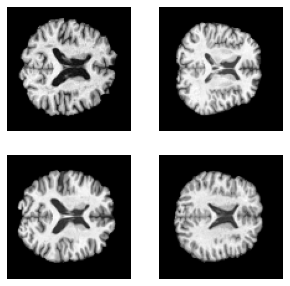

pMCI


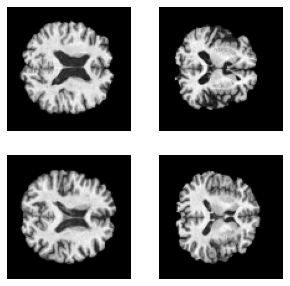

In [3]:
import random
import matplotlib.pyplot as plt
# visualize 4+4 image from sMCI and pMCI
print("Randomly choose 4 image in sMCI dataset and 4 image in pMCI dataset to visualize")
def visualize(dataset,seed=567):
  # set the size of canvas
  fig = plt.figure(figsize=(5,5))
  random.seed(seed)
  plt_index=1
  for i in random.sample(range(len(dataset)),4):
    # plot subgraph
    ax = fig.add_subplot(2,2,plt_index)
    plt.axis('off')
    ax.imshow(dataset[i][:,:,0],cmap='gray')
    plt_index+=1
  plt.show()

print("sMCI")
visualize(sMCI)
print("pMCI")
visualize(pMCI,seed=123)

# 2. preprocess
## 2.1 label image

In [4]:
import pandas as pd
# combine image and label to an array
# sMCI=0,pMCI=1
MCI=sMCI+pMCI
a=list([1,0] for i in range(len(sMCI)))
b=list([0,1] for i in range(len(pMCI)))
label=a+b
MCI_arr=np.array(MCI)
print(MCI_arr.shape)

(504, 100, 100, 3)


In [5]:
label=np.array(label)
print(label.shape)

(504, 2)


## 2.2 zero mean

In [6]:
from sklearn import preprocessing
MCI_arr = MCI_arr.astype("float")
# zero mean of X_train and X_test
for i in range(len(MCI_arr)):
  mean=np.mean(MCI_arr[i])
  MCI_arr[i]-=mean                                                       

## 2.3 split dataset


In [7]:
#  split data into 70%(train) + 30%(test)
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(MCI_arr,label,test_size=0.3,random_state=1,stratify=label)

# check
print("X_train shape :",X_train.shape)
print("y_train shape :",y_train.shape)
print("X_test shape :",X_test.shape)
print("y_test shape :",y_test.shape)

X_train shape : (352, 100, 100, 3)
y_train shape : (352, 2)
X_test shape : (152, 100, 100, 3)
y_test shape : (152, 2)


# 3. bulid model
## 3.1 GoogLeNet

In [8]:
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import AveragePooling2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.layers import concatenate
import matplotlib
matplotlib.use("Agg")
%matplotlib inline
from keras.callbacks import LearningRateScheduler
from keras.datasets import cifar10
import numpy as np

In [9]:

def conv_module(input,No_of_filters,filtersizeX,filtersizeY,stride,chanDim,padding="same"):
  input = Conv2D(No_of_filters,(filtersizeX,filtersizeY),strides=stride,padding=padding)(input)
  input = BatchNormalization(axis=chanDim)(input)
  input = Activation("relu")(input)
  return input

def inception_module(input,numK1x1,numK3x3,numk5x5,numPoolProj,chanDim):
                                 #Step 1
  conv_1x1 = conv_module(input, numK1x1, 1, 1,(1, 1), chanDim) 
                                 #Step 2
  conv_3x3 = conv_module(input, numK3x3, 3, 3,(1, 1), chanDim)
  conv_5x5 = conv_module(input, numk5x5, 5, 5,(1, 1), chanDim)
                                 #Step 3
  pool_proj = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input)
  pool_proj = Conv2D(numPoolProj, (1, 1), padding='same', activation='relu')(pool_proj)
                                 #Step 4
  input = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=chanDim)
  return input

def downsample_module(input,No_of_filters,chanDim):
  conv_3x3=conv_module(input,No_of_filters,3,3,(2,2),chanDim,padding="valid")
  pool = MaxPooling2D((3,3),strides=(2,2))(input)
  input = concatenate([conv_3x3,pool],axis=chanDim)
  return input


In [10]:
def GoogleNet(width,height,depth,classes):
  inputShape=(height,width,depth)
  chanDim=-1

  # (Step 1) Define the model input
  inputs = Input(shape=inputShape)

  # First CONV module
  x = conv_module(inputs, 96, 3, 3, (1, 1),chanDim)

  # (Step 2) Two Inception modules followed by a downsample module
  x = inception_module(x, 32, 32,32,32,chanDim)
  x = inception_module(x, 32, 48, 48,32,chanDim)
  x = downsample_module(x, 80, chanDim)
  
  # (Step 3) Five Inception modules followed by a downsample module
  x = inception_module(x, 112, 48, 32, 48,chanDim)
  x = inception_module(x, 96, 64, 32,32,chanDim)
  x = inception_module(x, 80, 80, 32,32,chanDim)
  x = inception_module(x, 48, 96, 32,32,chanDim)
  x = inception_module(x, 112, 48, 32, 48,chanDim)
  x = downsample_module(x, 96, chanDim)

  # (Step 4) Two Inception modules followed
  x = inception_module(x, 176, 160,96,96, chanDim)
  x = inception_module(x, 176, 160, 96,96,chanDim)
  
  # Global POOL and dropout
  x = AveragePooling2D((7, 7))(x)
  x = Dropout(0.5)(x)

  # (Step 5) Softmax classifier
  x = Flatten()(x)
  x = Dense(classes)(x)
  x = Activation("softmax")(x)

  # Create the model
  model = Model(inputs, x, name="googlenet")
  return model

In [11]:
INIT_LR = 5e-3
NUM_EPOCHS=70
def poly_decay(epoch):
  maxEpochs = NUM_EPOCHS
  baseLR = INIT_LR
  power = 1.0
  alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power
  return alpha

In [12]:
callbacks=[LearningRateScheduler(poly_decay)]
model = GoogleNet(width=100, height=100, depth=3, classes=2)
                                    # Step 1
model.compile(loss="categorical_crossentropy", optimizer='sgd',metrics=["accuracy"])
                                    # Step 2
model.summary()

Model: "googlenet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 100, 100, 96  2688        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 100, 100, 96  384        ['conv2d[0][0]']                 
 alization)                     )                                                         

## 3.2 train model

In [13]:
# Train your model for 50 epochs and batch size equal to 5
history = model.fit(X_train, y_train, batch_size=5,validation_split=0.2, epochs=NUM_EPOCHS, callbacks=callbacks, verbose=1)

Epoch 1/70
57/57 [==============================] - 26s 173ms/step - loss: 2.0671 - accuracy: 0.5196 - val_loss: 4.1288 - val_accuracy: 0.6338 - lr: 0.0050
Epoch 2/70
57/57 [==============================] - 7s 125ms/step - loss: 1.3342 - accuracy: 0.5587 - val_loss: 0.8109 - val_accuracy: 0.6479 - lr: 0.0049
Epoch 3/70
57/57 [==============================] - 7s 125ms/step - loss: 1.0771 - accuracy: 0.5374 - val_loss: 3.4784 - val_accuracy: 0.3662 - lr: 0.0049
Epoch 4/70
57/57 [==============================] - 7s 126ms/step - loss: 0.9649 - accuracy: 0.6050 - val_loss: 1.7881 - val_accuracy: 0.6338 - lr: 0.0048
Epoch 5/70
57/57 [==============================] - 7s 129ms/step - loss: 1.0643 - accuracy: 0.6157 - val_loss: 1.0902 - val_accuracy: 0.5634 - lr: 0.0047
Epoch 6/70
57/57 [==============================] - 7s 127ms/step - loss: 1.0332 - accuracy: 0.5943 - val_loss: 2.6351 - val_accuracy: 0.6338 - lr: 0.0046
Epoch 7/70
57/57 [==============================] - 7s 127ms/step - l

## 3.3 plot the loss function

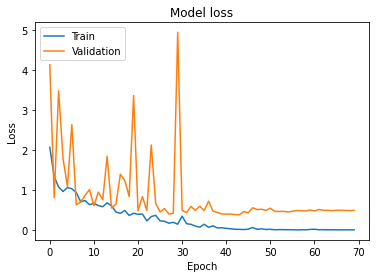

In [14]:

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## 3.4 check the prediction of the model

In [15]:
tmp=y_test
y_test=[]
for i in range(len(tmp)):
  maxindex = np.argmax(tmp[i])
  y_test.append(maxindex)
y_pred = model.predict(X_test) 
tmp=y_pred
y_pred=[]
for i in range(len(tmp)):
  maxindex = np.argmax(tmp[i])
  y_pred.append(maxindex)
print(y_test)
print(y_pred)

[1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
[1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0]


# 4 model evaluation
## 4.1 confusion matrix，accuracy and F1 score

the f1 score is 0.9124695459579182
the accuracy is 0.9144736842105263


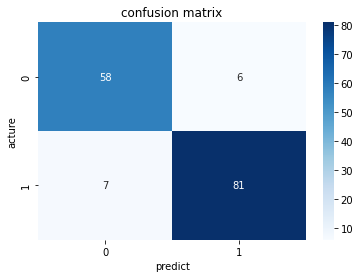

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import seaborn as sns

def plot_cm(x,y):
    '''this function is used to plot confusion matrix'''
    cm = confusion_matrix(x,y)
    n=cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1]
    acc=(cm[0][0]+cm[1][1])/n
    print("the accuracy is", acc)
    ax=sns.heatmap(cm,fmt='g',annot=True,cmap='Blues') 
    ax.set_title('confusion matrix') 
    ax.set_xlabel('predict') 
    ax.set_ylabel('acture') 
    plt.show()

print("the f1 score is",f1_score(y_test, y_pred, average='macro'))
plot_cm(y_test, y_pred)

## 4.2 roc curve and auc value

In [17]:
from sklearn.metrics import roc_curve,auc
import numpy as np

def plot_roc(x,y):
    '''this function is use to plot roc curve and find auc'''
    fpr, tpr, _ =roc_curve(x,y)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (auc = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

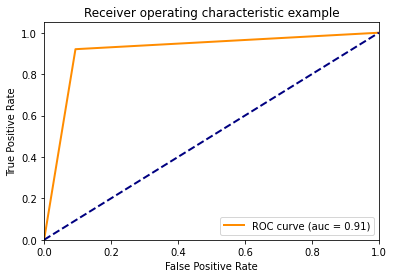

In [18]:
plot_roc(y_test,y_pred)

# 5 predict conversion time
## 5.1 import time information

In [19]:
# load the convert time information
conv_path = r'/content/drive/My Drive/data/convert_age.csv'
conv_df=pd.read_csv(conv_path)
conv_df=conv_df[["PTID","convertage"]]
conv_df

,PTID,convertage
0,002_S_0729,66.1
1,002_S_0954,70.3
2,002_S_1070,75.1
3,002_S_1268,88.7
4,002_S_4171,71.4
...,...,...
406,941_S_1311,70.1
407,941_S_1363,70.2
408,941_S_4365,89.8
409,941_S_6068,79.7


In [20]:
# load the pMCI information
p_path = r'/content/drive/My Drive/data/pMCI.csv'
p_df=pd.read_csv(p_path)
p_df=p_df[["Image Data ID","Subject","Group","Sex","Age"]]
p_df

,Image Data ID,Subject,Group,Sex,Age
0,I63896,941_S_1363,MCI,F,70
1,I89826,941_S_1295,MCI,M,77
2,I122390,941_S_1295,MCI,M,78
3,I63887,941_S_1295,MCI,M,77
4,I91270,141_S_0982,MCI,F,81
...,...,...,...,...,...
495,I121071,002_S_1070,MCI,M,75
496,I165274,002_S_1070,MCI,M,77
497,I86299,002_S_1070,MCI,M,75
498,I132205,002_S_1070,MCI,M,76


In [21]:
df=pd.merge(conv_df,p_df,left_on='PTID',right_on='Subject',how='inner')
# drop the row which age>convertage 
for i in range(len(df)):
  if(df["Age"][i]>df["convertage"][i]):
    df=df.drop([i])
df=df.reset_index(drop=True)
df

,PTID,convertage,Image Data ID,Subject,Group,Sex,Age
0,002_S_1070,75.1,I40830,002_S_1070,MCI,M,74
1,002_S_1070,75.1,I121071,002_S_1070,MCI,M,75
2,002_S_1070,75.1,I86299,002_S_1070,MCI,M,75
3,002_S_1070,75.1,I60473,002_S_1070,MCI,M,74
4,003_S_1057,63.2,I52820,003_S_1057,MCI,F,61
...,...,...,...,...,...,...,...
346,141_S_0982,81.2,I91293,141_S_0982,MCI,F,81
347,941_S_1295,78.2,I89826,941_S_1295,MCI,M,77
348,941_S_1295,78.2,I122390,941_S_1295,MCI,M,78
349,941_S_1295,78.2,I63887,941_S_1295,MCI,M,77


## 5.2 use the trained GoogLeNet to give the probability for each image

In [22]:
prob_list=[]
for i in range(len(df)):
  img_path=r'/content/drive/My Drive/data/pMCI/'+df["Image Data ID"][i]+".nii.nii"
  if os.path.exists(img_path):

    # preprocess nii file
    # read the nifti file
    img=nib.load(img_path)
    # convert to array
    img_arr=img.get_fdata()
    img_arr=np.squeeze(img_arr)
    # choose 3 slices from one quarter, one half, three quarter height and concat
    res=np.stack((img_arr[:,:,int(q2*182)],img_arr[:,:,int(q3*182)],img_arr[:,:,int(q1*182)]),axis=-1)
    # resize the array
    res = resize(res, (length, width, height))
    arr=np.array([res])
    arr = arr.astype("float")
    # zero mean
    mean = np.mean(arr)
    arr -= mean

    # use the train googlenet to predict the probabilty
    prob=model.predict(arr)[0][1]
  else:
    prob=-1
  prob_list.append(prob)

In [23]:
df["prob"]=prob_list
# strengthen the prob
df["stg_prob"]=1000*(1-df["prob"])
df

,PTID,convertage,Image Data ID,Subject,Group,Sex,Age,prob,stg_prob
0,002_S_1070,75.1,I40830,002_S_1070,MCI,M,74,0.962967,37.033081
1,002_S_1070,75.1,I121071,002_S_1070,MCI,M,75,0.987664,12.336075
2,002_S_1070,75.1,I86299,002_S_1070,MCI,M,75,0.998345,1.655340
3,002_S_1070,75.1,I60473,002_S_1070,MCI,M,74,0.974371,25.629401
4,003_S_1057,63.2,I52820,003_S_1057,MCI,F,61,-1.000000,2000.000000
...,...,...,...,...,...,...,...,...,...
346,141_S_0982,81.2,I91293,141_S_0982,MCI,F,81,0.999562,0.437558
347,941_S_1295,78.2,I89826,941_S_1295,MCI,M,77,0.999967,0.033021
348,941_S_1295,78.2,I122390,941_S_1295,MCI,M,78,0.999926,0.073671
349,941_S_1295,78.2,I63887,941_S_1295,MCI,M,77,0.999991,0.008702


In [24]:
# drop the row which prob<0 
for i in range(len(df)):
  if(df["prob"][i]<0):
    df=df.drop([i])
df=df.reset_index(drop=True)
df

,PTID,convertage,Image Data ID,Subject,Group,Sex,Age,prob,stg_prob
0,002_S_1070,75.1,I40830,002_S_1070,MCI,M,74,0.962967,37.033081
1,002_S_1070,75.1,I121071,002_S_1070,MCI,M,75,0.987664,12.336075
2,002_S_1070,75.1,I86299,002_S_1070,MCI,M,75,0.998345,1.655340
3,002_S_1070,75.1,I60473,002_S_1070,MCI,M,74,0.974371,25.629401
4,006_S_0675,80.8,I88345,006_S_0675,MCI,F,80,0.995044,4.955530
...,...,...,...,...,...,...,...,...,...
192,141_S_0982,81.2,I91293,141_S_0982,MCI,F,81,0.999562,0.437558
193,941_S_1295,78.2,I89826,941_S_1295,MCI,M,77,0.999967,0.033021
194,941_S_1295,78.2,I122390,941_S_1295,MCI,M,78,0.999926,0.073671
195,941_S_1295,78.2,I63887,941_S_1295,MCI,M,77,0.999991,0.008702


In [25]:
df["converttime"]=df["convertage"]-df["Age"]
df

,PTID,convertage,Image Data ID,Subject,Group,Sex,Age,prob,stg_prob,converttime
0,002_S_1070,75.1,I40830,002_S_1070,MCI,M,74,0.962967,37.033081,1.1
1,002_S_1070,75.1,I121071,002_S_1070,MCI,M,75,0.987664,12.336075,0.1
2,002_S_1070,75.1,I86299,002_S_1070,MCI,M,75,0.998345,1.655340,0.1
3,002_S_1070,75.1,I60473,002_S_1070,MCI,M,74,0.974371,25.629401,1.1
4,006_S_0675,80.8,I88345,006_S_0675,MCI,F,80,0.995044,4.955530,0.8
...,...,...,...,...,...,...,...,...,...,...
192,141_S_0982,81.2,I91293,141_S_0982,MCI,F,81,0.999562,0.437558,0.2
193,941_S_1295,78.2,I89826,941_S_1295,MCI,M,77,0.999967,0.033021,1.2
194,941_S_1295,78.2,I122390,941_S_1295,MCI,M,78,0.999926,0.073671,0.2
195,941_S_1295,78.2,I63887,941_S_1295,MCI,M,77,0.999991,0.008702,1.2


In [26]:
# encoder "Group" and "Sex"
df["Group"].replace("MCI",0.5,inplace=True) 
df["Group"].replace("EMCI",0,inplace=True) 
df["Group"].replace("LMCI",1,inplace=True) 
df["Sex"].replace("F",0,inplace=True)
df["Sex"].replace("M",0,inplace=True)
df

,PTID,convertage,Image Data ID,Subject,Group,Sex,Age,prob,stg_prob,converttime
0,002_S_1070,75.1,I40830,002_S_1070,0.5,0,74,0.962967,37.033081,1.1
1,002_S_1070,75.1,I121071,002_S_1070,0.5,0,75,0.987664,12.336075,0.1
2,002_S_1070,75.1,I86299,002_S_1070,0.5,0,75,0.998345,1.655340,0.1
3,002_S_1070,75.1,I60473,002_S_1070,0.5,0,74,0.974371,25.629401,1.1
4,006_S_0675,80.8,I88345,006_S_0675,0.5,0,80,0.995044,4.955530,0.8
...,...,...,...,...,...,...,...,...,...,...
192,141_S_0982,81.2,I91293,141_S_0982,0.5,0,81,0.999562,0.437558,0.2
193,941_S_1295,78.2,I89826,941_S_1295,0.5,0,77,0.999967,0.033021,1.2
194,941_S_1295,78.2,I122390,941_S_1295,0.5,0,78,0.999926,0.073671,0.2
195,941_S_1295,78.2,I63887,941_S_1295,0.5,0,77,0.999991,0.008702,1.2


## 5.3 build neural network model to predict the convert time
use features=["age","prob"] target=["converttime"] to build neural network

In [27]:
# preprocess data
data=df[["Group",	"Sex", "Age",	"stg_prob",	"converttime"]]
# Normalize data
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0, 1))
data_norm=scaler.fit_transform(data)
# record scaler
scale=scaler.scale_
# Split data into training set(70%) and test set(30%)
X=np.array(data_norm[:,:4])
y=[[i] for i in data_norm[:,4]]
y=np.array(y)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
# check
print("X_train shape :",X_train.shape)
print("y_train shape :",y_train.shape)
print("X_test shape :",X_test.shape)
print("y_test shape :",y_test.shape)

X_train shape : (137, 4)
y_train shape : (137, 1)
X_test shape : (60, 4)
y_test shape : (60, 1)


In [28]:
# Define NN model as a Keras sequential model
import numpy as np
from keras.models import Sequential
from tensorflow import random
random.set_seed(321)
np.random.seed(321)
model2 = Sequential()

# Add one hidden layer of size 7 with activation function of type tanh 
from keras.layers import Dense, Activation
model2.add(Dense(7, activation='tanh', input_dim=X_train.shape[1]))
# Add another hidden layer of size 10, with activation function of type tanh
model2.add(Dense(10, activation='tanh'))
# Add another hidden layer of size 6, with activation function of type tanh 
model2.add(Dense(6, activation='tanh'))
# Add the output layer with sigmoid activation function
model2.add(Dense(1, activation='sigmoid'))

# Choose the loss function to be Mean Squared Error and the optimizer to be SGD for training the model
model2.compile(optimizer='sgd', loss='mse', metrics=['accuracy'])
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 7)                 35        
                                                                 
 dense_2 (Dense)             (None, 10)                80        
                                                                 
 dense_3 (Dense)             (None, 6)                 66        
                                                                 
 dense_4 (Dense)             (None, 1)                 7         
                                                                 
Total params: 188
Trainable params: 188
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Train your model for 100 epochs and batch size equal to 5
history2 = model2.fit(X_train, y_train, epochs=500, batch_size=10, verbose=1, validation_split=0.2, shuffle=False)

Epoch 1/500
11/11 [==============================] - 1s 17ms/step - loss: 0.0868 - accuracy: 0.0550 - val_loss: 0.0746 - val_accuracy: 0.0714
Epoch 2/500
11/11 [==============================] - 0s 5ms/step - loss: 0.0838 - accuracy: 0.0642 - val_loss: 0.0731 - val_accuracy: 0.0714
Epoch 3/500
11/11 [==============================] - 0s 5ms/step - loss: 0.0814 - accuracy: 0.0642 - val_loss: 0.0719 - val_accuracy: 0.0714
Epoch 4/500
11/11 [==============================] - 0s 5ms/step - loss: 0.0794 - accuracy: 0.0642 - val_loss: 0.0711 - val_accuracy: 0.0714
Epoch 5/500
11/11 [==============================] - 0s 5ms/step - loss: 0.0779 - accuracy: 0.0642 - val_loss: 0.0705 - val_accuracy: 0.0714
Epoch 6/500
11/11 [==============================] - 0s 5ms/step - loss: 0.0766 - accuracy: 0.0642 - val_loss: 0.0701 - val_accuracy: 0.0714
Epoch 7/500
11/11 [==============================] - 0s 5ms/step - loss: 0.0755 - accuracy: 0.0642 - val_loss: 0.0698 - val_accuracy: 0.0714
Epoch 8/500


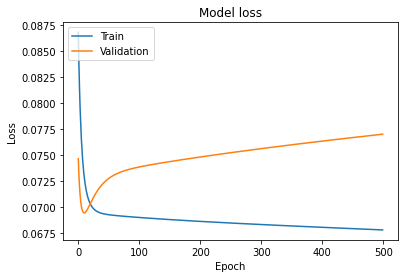

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot training & validation loss values
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## 5.4 evaluate model and prediction results

The RMSE of this model is 2.221654604660964
The MAE of this model is 1.7207842867324747
The R2 of this model is 0.052737796151468896


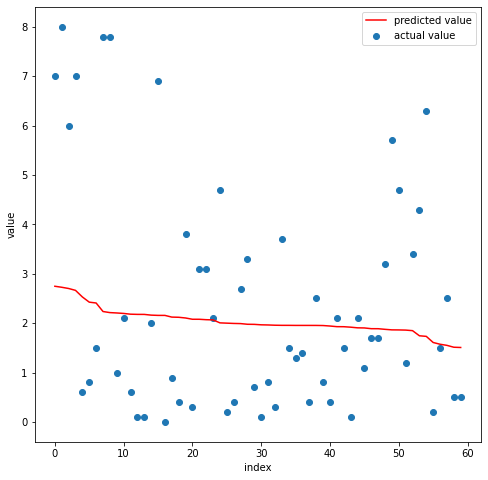

In [31]:
# Use your trained model to predict for test data set
y_pred = model2.predict(X_test) 
y_test
# Denormalization
y_test_den=[]
y_pred_den=[]
for i in range(len(y_test)):
    y_test_den.append(y_test[i][0]/scale[4]+data["converttime"].min())
    y_pred_den.append(y_pred[i][0]/scale[4]+data["converttime"].min())
    
# plot the prediction result and calculate the RMSE to evaluate the model
def evaluate_pred(actual,pred):
    n=len(actual)
    
    # calculta the RMSE
    RMSE=0
    aa=0
    mm=np.mean(actual)
    for i in range(n):
        RMSE+=(actual[i]-pred[i])**2
        aa+=(actual[i]-mm)**2
    RMSE=(RMSE/n)**0.5
    print("The RMSE of this model is",RMSE)
    
    # calculta the RMSE
    MAE=0
    for i in range(n):
        MAE+=abs(actual[i]-pred[i])
    MAE=MAE/n
    print("The MAE of this model is",MAE)
    
    # calculta the RMSE
    R2=1-(RMSE**2*n)/aa
    print("The R2 of this model is",R2)
    
    x=range(n)
    # sort data according to pred 
    Z=zip(pred,actual)
    Z=sorted(Z,reverse=True)
    pred_new,actual_new=zip(*Z)
    
    # plot the prediction result and actual result
    plt.figure(figsize=(8,8))
    plt.scatter(x,actual_new,label="actual value")
    plt.plot(x,pred_new, color="r",label="predicted value")
    plt.xlabel("index")
    plt.ylabel("value")
    plt.legend(loc="upper right")
    plt.show()
    
evaluate_pred(y_test_den,y_pred_den)